In [1]:
import pandas as pd
import jieba
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

In [2]:
# 读入数据
data = pd.read_csv('文本聚类数据2.csv')
data.head()

,类别,文本
0,娱乐,霉霉或将献唱《芭比》电影原声带 官方暂未确认
1,娱乐,许光汉回应加盟《中餐厅》：可以期待一下
2,娱乐,小S说自己有容貌焦虑：在餐厅吃饭会不停照镜子
3,娱乐,龟梨和也出演三池崇史新片《怪物樵夫》
4,娱乐,福建省泉州市丰泽区影视文旅产业推介会举办


In [3]:
print(data.shape)
data['类别'].value_counts()

(10000, 2)


娱乐    2500
军事    2500
科技    2500
财经    2500
Name: 类别, dtype: int64

In [4]:
# 处理数据（分词，去除停用词）
def chinese_word_cut(mytext):
    # 文本预处理 ：去除一些无用的字符只提取出中文出来
    new_data = re.findall('[\u4e00-\u9fa5]+', mytext, re.S)
    new_data = " ".join(new_data)
 
    # 文本分词
    seg_list_exact = jieba.cut(new_data)
    result_list = []
    # 加载停用词库
    with open('stopwords.txt', encoding='utf-8') as f: # 可根据需要打开停用词库，然后加上不想显示的词语
        stop_words = set()
        for i in f.readlines():
            stop_words.add(i.replace("\n", "")) # 去掉读取每一行数据的\n
    # 去除停用词
    for word in seg_list_exact:
        if word not in stop_words and len(word) > 1:
            result_list.append(word)      
    return " ".join(result_list)
 
data['分词结果'] = data['文本'].apply(chinese_word_cut)
data['分词结果']

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\55442\AppData\Local\Temp\jieba.cache
Loading model cost 0.571 seconds.
Prefix dict has been built successfully.


0                       霉霉 芭比 电影 原声带 官方 暂未 确认
1                            许光汉 回应 加盟 中餐厅 期待
2                          容貌 焦虑 餐厅 吃饭 不停 照镜子
3                           出演 三池 崇史 新片 怪物 樵夫
4                 福建省 泉州市 丰泽区 影视 文旅 产业 推介会 举办
                        ...                  
9995    合力 泰拟 易主 提前 泄露 内幕消息 接盘 溢价 收购 原实 控人 入局
9996      欢乐 椰子汁 营收 亿占 半壁江山 亿建 越南 项目 布局 上游 原料
9997          海南 矿业 净利 董事长 薪酬 股价 过山车 两大 股东 套现
9998              海兴 电力 中标 项目 海内外 双轮 驱动 手握 现金
9999              光迅 科技 推进 股权 激励 留人 获授 员工 浮盈超
Name: 分词结果, Length: 10000, dtype: object

In [5]:
# 文本数据转为向量并降维
vectorizer = CountVectorizer()
svd = TruncatedSVD(100)  # 数据降维处理
normalizer = Normalizer(copy=False)  # 标准化
lsa = make_pipeline(svd,normalizer)
X = lsa.fit_transform(vectorizer.fit_transform(data['分词结果']))
X.shape

(10000, 100)

In [6]:
# 用TF—IDF计算词向量
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X)
tfidf_weight = tfidf.toarray()
print(len(tfidf_weight[0]))
print(tfidf_weight)

100
[[ 0.02104327  0.0529001   0.00270881 ...  0.05464272 -0.04322865
  -0.03450253]
 [ 0.01492356  0.05573902  0.04346665 ... -0.08313291 -0.11130569
   0.06184037]
 [ 0.003178    0.01715638  0.03136252 ... -0.15461958  0.04013303
  -0.24857152]
 ...
 [ 0.00688377  0.04923027  0.05237458 ... -0.14477366  0.07246707
   0.10524718]
 [ 0.00344418  0.02502677  0.02229407 ...  0.04445721  0.09993448
  -0.19197058]
 [ 0.01091782  0.08091619  0.12725116 ... -0.071953   -0.0084515
  -0.11622611]]


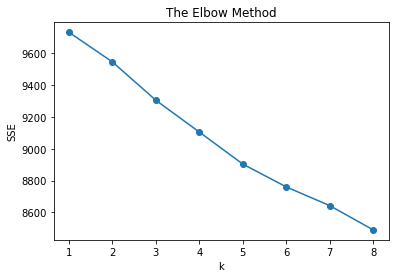

In [10]:
# 利用SSE选择k,分析最优聚类数（手肘法）
SSE = []  # 存放每次结果的误差平方和
for k in range(1,9):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(tfidf_weight)
    SSE.append(estimator.inertia_) # estimator.inertia_获取聚类准则的总和
X = range(1,9)
# 绘制SSE图像（拐点处为最优聚类个数）
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.savefig('elbow.png')
plt.show()

In [8]:
# 指定分成4个类
kmeans = KMeans(n_clusters=4,random_state=0,init="k-means++",n_init=50)
kmeans.fit(tfidf_weight)
# 打印出各个簇的中心点
print("中心点坐标：")
print(kmeans.cluster_centers_)
for index, label in enumerate(kmeans.labels_, 1):
    print("index: {}, label: {}".format(index, label))
# 样本距其最近的聚类中心的平方距离之和，用来评判分类的准确度，值越小越好
# k-means的超参数n_clusters可以通过该值来评估
print("效果评估值：")
print("inertia: {}".format(kmeans.inertia_))
data.head()
# 保存聚类结果
data['label'] = kmeans.labels_
data.to_csv("处理后的数据2.csv",index=False,encoding='utf-8-sig')
data.head

中心点坐标：
[[ 3.21356505e-02  5.14974908e-02  6.16103258e-02  3.80007042e-02
   3.62230586e-02  6.79882090e-03  7.73376210e-03 -1.61838818e-02
   4.82759343e-02  6.14643300e-02 -2.53350253e-02 -1.46356812e-03
   1.85077920e-02 -9.58899181e-03  3.36258326e-02  2.99221721e-04
   2.72960338e-02  7.54843337e-03  1.53201182e-02  4.65419283e-03
   3.31590273e-03 -3.98758210e-03  1.70880012e-02  3.13062675e-02
  -1.17941496e-02  7.22750314e-03  8.78469987e-03  7.51797514e-03
   9.65771813e-03 -1.21350410e-02  6.73577813e-03 -1.88304140e-03
   5.15478963e-03 -3.04077004e-03  8.96363911e-03  5.28267978e-03
   6.58509307e-03 -2.84686218e-02 -5.67609778e-03 -9.47840873e-03
   9.59535286e-03  1.87580590e-02 -4.36511418e-03 -1.02794968e-02
   5.74046404e-03 -9.35899395e-03  3.92356809e-03  3.69059297e-04
   4.78895485e-03  7.94386742e-03 -1.23308086e-02  1.39548038e-02
   2.07044774e-03 -9.20861426e-03  1.06544729e-02 -5.49223366e-03
   2.04159821e-03 -1.54753239e-02  1.48294215e-02 -3.24840133e-03
  -

<bound method NDFrame.head of       类别                                         文本  \
0     娱乐                     霉霉或将献唱《芭比》电影原声带 官方暂未确认   
1     娱乐                        许光汉回应加盟《中餐厅》：可以期待一下   
2     娱乐                     小S说自己有容貌焦虑：在餐厅吃饭会不停照镜子   
3     娱乐                         龟梨和也出演三池崇史新片《怪物樵夫》   
4     娱乐                       福建省泉州市丰泽区影视文旅产业推介会举办   
...   ..                                        ...   
9995  财经  合力泰拟逾30亿易主疑提前泄露内幕消息 “接盘侠”溢价55%收购原实控人之女或入局   
9996  财经        欢乐家椰子汁年营收8亿占半壁江山 拟投1.31亿建越南项目布局上游原料   
9997  财经      海南矿业净利降30%董事长薪酬增40万 股价坐过山车前两大股东套现逾13亿   
9998  财经              海兴电力预中标3.66亿项目 海内外双轮驱动手握38亿现金   
9999  财经                光迅科技推进股权激励留人 741名获授员工已浮盈超3亿   

                                       分词结果  label  
0                     霉霉 芭比 电影 原声带 官方 暂未 确认      2  
1                          许光汉 回应 加盟 中餐厅 期待      2  
2                        容貌 焦虑 餐厅 吃饭 不停 照镜子      2  
3                         出演 三池 崇史 新片 怪物 樵夫      2  
4               福建省 泉州市 丰泽区 影视 文旅 产业 推介会 举办 

d:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


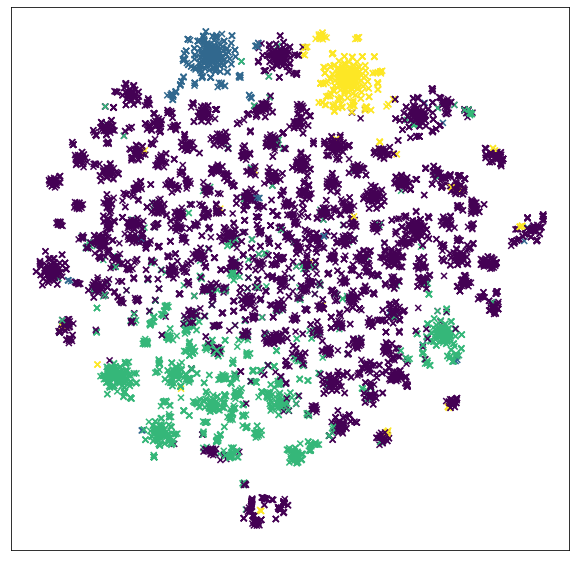

In [9]:
# 用TSNE进行数据降维并展示聚类结果
# 使用T-SNE算法，对权重进行降维，准确度比PCA算法高，但是耗时长
tsne = TSNE(n_components=2)
decomposition_data = tsne.fit_transform(tfidf_weight)
 
x = []
y = []
 
for i in decomposition_data:
    x.append(i[0])
    y.append(i[1])
    
# 绘制聚类结果
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
plt.scatter(x, y, c=kmeans.labels_, marker="x")
plt.xticks(())
plt.yticks(())
plt.show()

In [13]:
# 根据聚类结果确定类别标签并计算模型准确率
data['cata'] = data['类别']
print(data.head)
data['cata'].replace(to_replace={'娱乐':2,'军事':3,'科技':1,'财经':0},inplace=True)

right = 0
error = 0
for i,j in zip(data['cata'],data['label']):
    if i == j:
        right+=1
    else:
        error+=1
print('模型分类准确率：',right/(right+error))

<bound method NDFrame.head of       类别                                         文本  \
0     娱乐                     霉霉或将献唱《芭比》电影原声带 官方暂未确认   
1     娱乐                        许光汉回应加盟《中餐厅》：可以期待一下   
2     娱乐                     小S说自己有容貌焦虑：在餐厅吃饭会不停照镜子   
3     娱乐                         龟梨和也出演三池崇史新片《怪物樵夫》   
4     娱乐                       福建省泉州市丰泽区影视文旅产业推介会举办   
...   ..                                        ...   
9995  财经  合力泰拟逾30亿易主疑提前泄露内幕消息 “接盘侠”溢价55%收购原实控人之女或入局   
9996  财经        欢乐家椰子汁年营收8亿占半壁江山 拟投1.31亿建越南项目布局上游原料   
9997  财经      海南矿业净利降30%董事长薪酬增40万 股价坐过山车前两大股东套现逾13亿   
9998  财经              海兴电力预中标3.66亿项目 海内外双轮驱动手握38亿现金   
9999  财经                光迅科技推进股权激励留人 741名获授员工已浮盈超3亿   

                                       分词结果  label cata  
0                     霉霉 芭比 电影 原声带 官方 暂未 确认      2   娱乐  
1                          许光汉 回应 加盟 中餐厅 期待      2   娱乐  
2                        容貌 焦虑 餐厅 吃饭 不停 照镜子      2   娱乐  
3                         出演 三池 崇史 新片 怪物 樵夫      2   娱乐  
4               福建省